# Wine Seller Marketing Campaign

## Dependencies 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from scipy.stats import gaussian_kde
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import shap
from sklearn.metrics import log_loss
import lightgbm as lgb

#     https://www.kaggle.com/rodsaldanha/arketing-campaign

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [2]:
dataset = pd.read_excel('marketing_campaign.xlsx')
df =  pd.DataFrame(dataset)
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1503,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85,...,1,0,0,0,0,0,0,3,11,0
1,1501,1982,PhD,Married,160803.0,0,0,2012-08-04,21,55,...,0,0,0,0,0,0,0,3,11,0
2,5336,1971,Master,Together,157733.0,1,0,2013-06-04,37,39,...,1,0,0,0,0,0,0,3,11,0
3,8475,1973,PhD,Married,157243.0,0,1,2014-03-01,98,20,...,0,0,0,0,0,0,0,3,11,0
4,4931,1977,Graduation,Together,157146.0,0,0,2013-04-29,13,1,...,1,0,0,0,0,0,0,3,11,0


In [ ]:
# AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
# AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
# AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
# AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
# AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
# Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
# Complain - 1 if customer complained in the last 2 years
# DtCustomer - date of customer’s enrolment with the company
# Education - customer’s level of education
# Marital - customer’s marital status
# Kidhome - number of small children in customer’s household
# Teenhome - number of teenagers in customer’s household
# Income - customer’s yearly household income
# MntFishProducts - amount spent on fish products in the last 2 years
# MntMeatProducts - amount spent on meat products in the last 2 years
# MntFruits - amount spent on fruits products in the last 2 years
# MntSweetProducts - amount spent on sweet products in the last 2 years
# MntWines - amount spent on wine products in the last 2 years
# MntGoldProds - amount spent on gold products in the last 2 years
# NumDealsPurchases - number of purchases made with discount
# NumCatalogPurchases - number of purchases made using catalogue
# NumStorePurchases - number of purchases made directly in stores
# NumWebPurchases - number of purchases made through company’s web site
# NumWebVisitsMonth - number of visits to company’s web site in the last month
# Recency - number of days since the last purchase


### Got just months from Dt_Customer

In [3]:
dates = df['Dt_Customer'].str.slice(stop=7)
df['Dt_Customer'] = dates
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1503,1976,PhD,Together,162397.0,1,1,2013-06,31,85,...,1,0,0,0,0,0,0,3,11,0
1,1501,1982,PhD,Married,160803.0,0,0,2012-08,21,55,...,0,0,0,0,0,0,0,3,11,0
2,5336,1971,Master,Together,157733.0,1,0,2013-06,37,39,...,1,0,0,0,0,0,0,3,11,0
3,8475,1973,PhD,Married,157243.0,0,1,2014-03,98,20,...,0,0,0,0,0,0,0,3,11,0
4,4931,1977,Graduation,Together,157146.0,0,0,2013-04,13,1,...,1,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2239 non-null   int64  
 1   Year_Birth           2239 non-null   int64  
 2   Education            2239 non-null   object 
 3   Marital_Status       2239 non-null   object 
 4   Income               2215 non-null   float64
 5   Kidhome              2239 non-null   int64  
 6   Teenhome             2239 non-null   int64  
 7   Dt_Customer          2239 non-null   object 
 8   Recency              2239 non-null   int64  
 9   MntWines             2239 non-null   int64  
 10  MntFruits            2239 non-null   int64  
 11  MntMeatProducts      2239 non-null   int64  
 12  MntFishProducts      2239 non-null   int64  
 13  MntSweetProducts     2239 non-null   int64  
 14  MntGoldProds         2239 non-null   int64  
 15  NumDealsPurchases    2239 non-null   i

### Convert Categorical Data 

In [5]:
#df = df.drop(columns= 'Dt_Customer')

cat_cols = df.columns[df.dtypes.values == "object"]
cat_cols

Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object')

In [6]:
train_df = pd.get_dummies(df, columns=cat_cols)

In [7]:
train_df.head(5)

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Dt_Customer_2013-09,Dt_Customer_2013-10,Dt_Customer_2013-11,Dt_Customer_2013-12,Dt_Customer_2014-01,Dt_Customer_2014-02,Dt_Customer_2014-03,Dt_Customer_2014-04,Dt_Customer_2014-05,Dt_Customer_2014-06
0,1503,1976,162397.0,1,1,31,85,1,16,2,...,0,0,0,0,0,0,0,0,0,0
1,1501,1982,160803.0,0,0,21,55,16,1622,17,...,0,0,0,0,0,0,0,0,0,0
2,5336,1971,157733.0,1,0,37,39,1,9,2,...,0,0,0,0,0,0,0,0,0,0
3,8475,1973,157243.0,0,1,98,20,2,1582,1,...,0,0,0,0,0,0,1,0,0,0
4,4931,1977,157146.0,0,0,13,1,0,1725,2,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df["Response"].value_counts()

0    1905
1     334
Name: Response, dtype: int64

## Train Test Split

In [9]:
# Took out Recency
# Took out Accepted in each campaign


X = train_df[['Year_Birth', 'Income', 'Kidhome', 'Teenhome',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO', 'Dt_Customer_2012-07',
       'Dt_Customer_2012-08', 'Dt_Customer_2012-09', 'Dt_Customer_2012-10',
       'Dt_Customer_2012-11', 'Dt_Customer_2012-12', 'Dt_Customer_2013-01',
       'Dt_Customer_2013-02', 'Dt_Customer_2013-03', 'Dt_Customer_2013-04',
       'Dt_Customer_2013-05', 'Dt_Customer_2013-06', 'Dt_Customer_2013-07',
       'Dt_Customer_2013-08', 'Dt_Customer_2013-09', 'Dt_Customer_2013-10',
       'Dt_Customer_2013-11', 'Dt_Customer_2013-12', 'Dt_Customer_2014-01',
       'Dt_Customer_2014-02', 'Dt_Customer_2014-03', 'Dt_Customer_2014-04',
       'Dt_Customer_2014-05', 'Dt_Customer_2014-06']]
y = train_df['Response'].values.reshape(-1, 1)
print(X.shape, y.shape)

(2239, 55) (2239, 1)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## XGB Classifier

In [11]:
from xgboost import XGBClassifier

In [12]:
my_model = XGBClassifier(

n_estimators=3000, 
colsample_bylevel=1, 
colsample_bynode=1,   
colsample_bytree=.50, 
learning_rate=0.05,
max_depth=6, 
min_child_weight=3,    
reg_alpha=0, 
reg_lambda=1, 
subsample=.75, 
drop_rate = 0.3,
min_data = 100,
lambda_l2 = 0.1,
lambda_l1 = 0.1,
bagging_fraction = 0.75,
bagging_freq = 1,
min_split_gain = 0.5,
verbose = 1,
feature_fraction = 0.25,
max_bin = 63,
num_threads = 6
)

my_model.fit(X_train, y_train,
            early_stopping_rounds=500, 
             eval_set=[(X_test, y_test.ravel())],
             verbose=False)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(bagging_fraction=0.75, bagging_freq=1, base_score=0.5,
              booster=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5, drop_rate=0.3, feature_fraction=0.25,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, lambda_l1=0.1, lambda_l2=0.1,
              learning_rate=0.05, max_bin=63, max_delta_step=0, max_depth=6,
              min_child_weight=3, min_data=100, min_split_gain=0.5, missing=nan,
              monotone_constraints=None, n_estimators=3000, n_jobs=0,
              num_parallel_tree=1, num_threads=6, objective='binary:logistic',
              random_state=0, ...)

In [13]:
scores = my_model.score(X_test, y_test)
scores

# Was 0.8596428571428572 at beginning


0.8714285714285714

In [14]:
y_pred = my_model.predict_proba(X_test)[:,1]

log_loss(y_test, y_pred, eps=1e-15)


0.3250188021172237

## Shap Visualizations 

In [15]:
shap_values = shap.TreeExplainer(my_model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


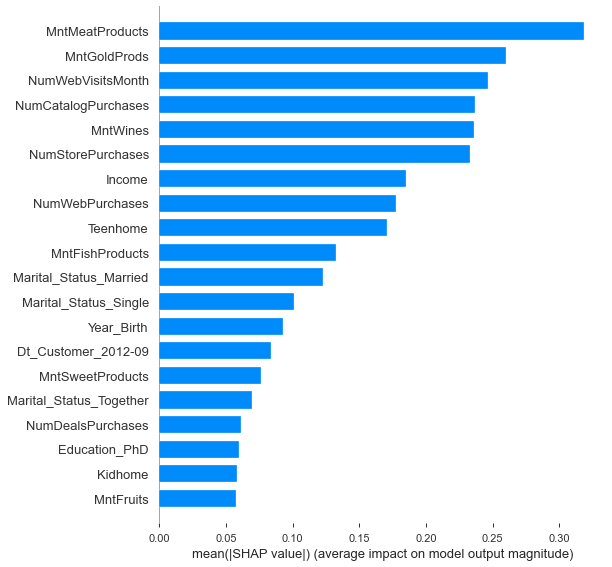

In [16]:
shap.summary_plot(shap_values, X_train, X_train.columns, plot_type="bar")

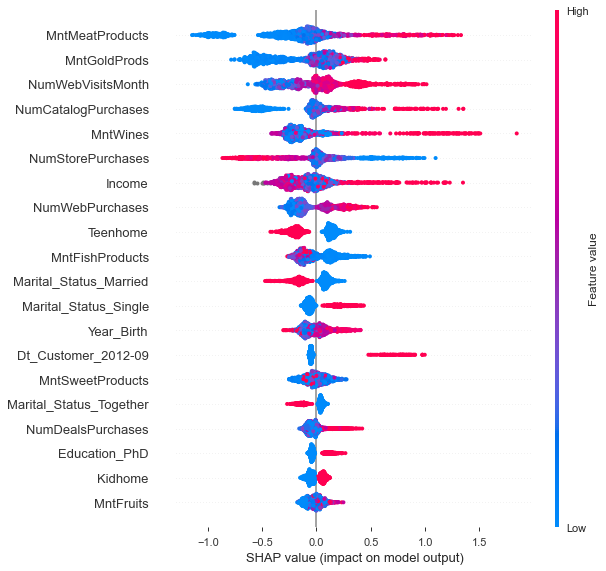

In [17]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)

In [18]:
features = list(X_train)

In [19]:
class ShapFeatureSelection:
    def __init__(self, my_model, X, feature_names):
        self.my_model = my_model
        self.X = X
        self.feature_names = feature_names
        self.shap_values = self._get_shap_values(my_model, X)
        
    def _get_shap_values(self, my_model, X):
        return shap.TreeExplainer(my_model).shap_values(X_train)
    
    def _get_shap_index(self, shap_values):
        return np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
        
    def get_top_features(self, n=10):
        feature_order = self._get_shap_index(self.shap_values)
        idx = feature_order[-min(n,len(feature_order)):]
        return [self.feature_names[i] for i in idx[::-1]]
    
    
fs = ShapFeatureSelection(my_model, X, features)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


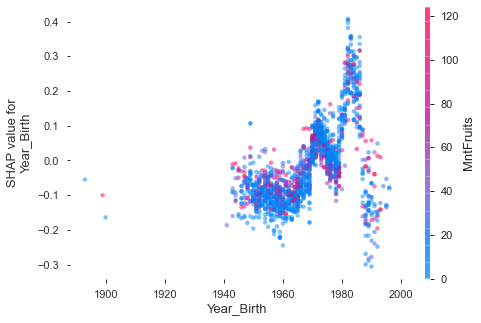

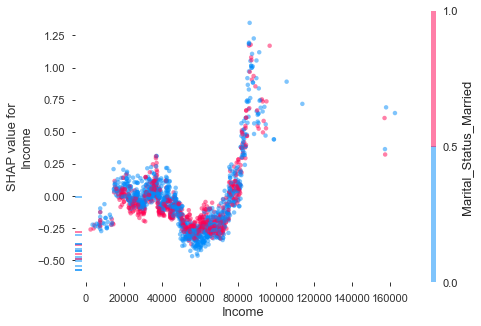

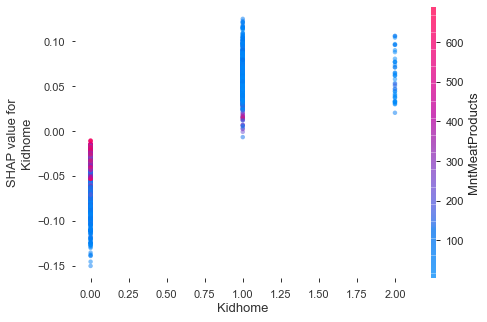

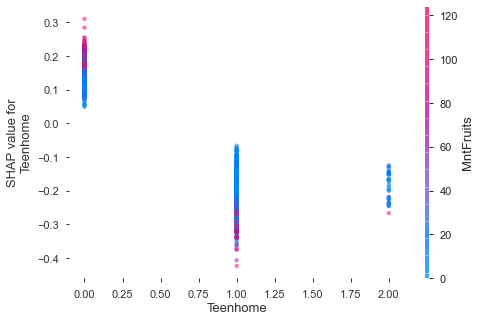

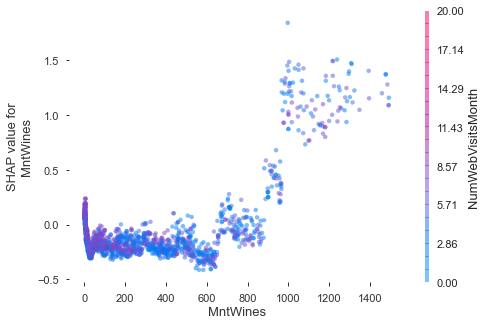

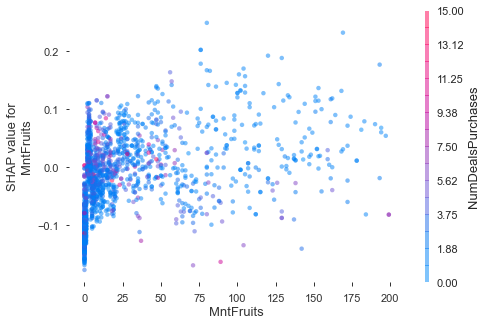

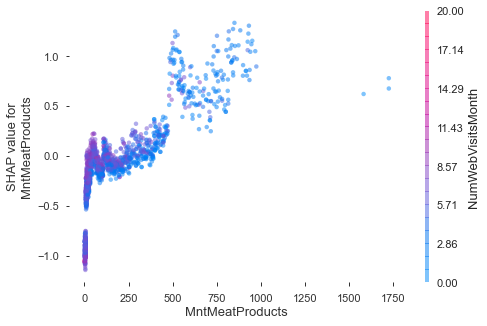

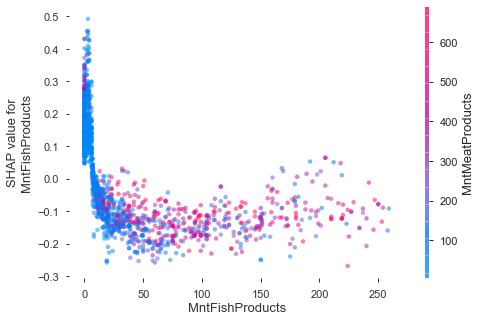

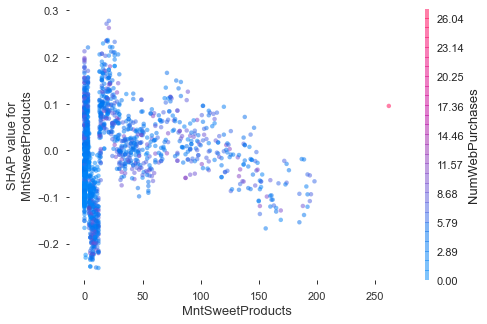

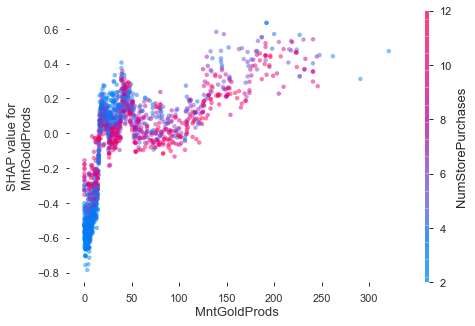

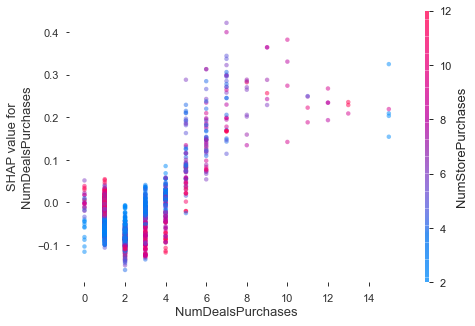

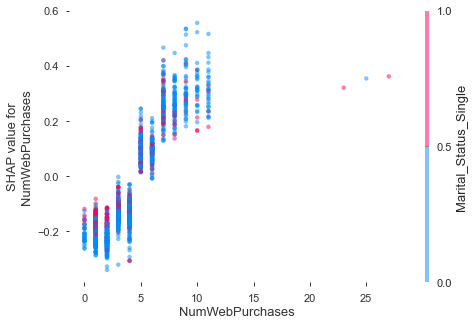

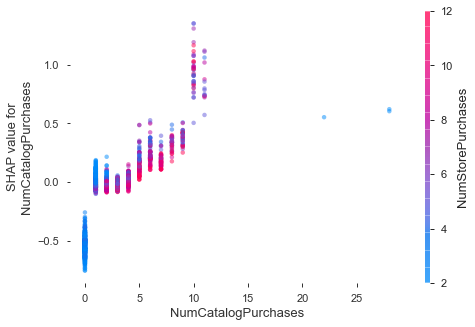

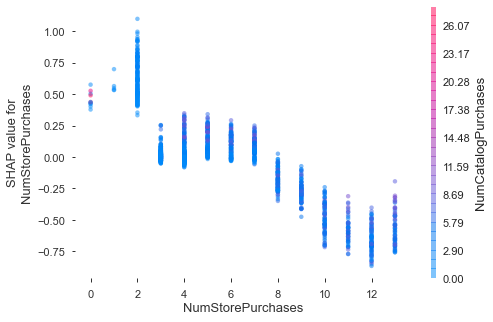

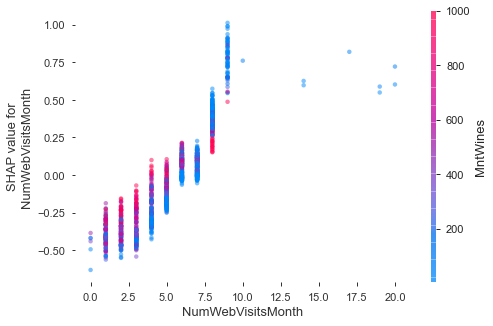

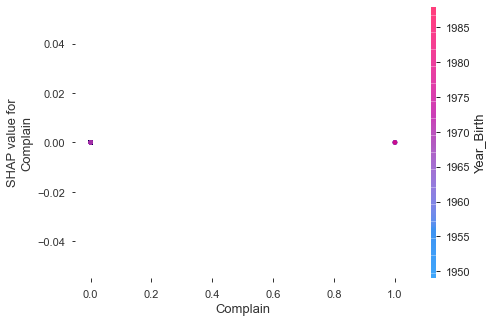

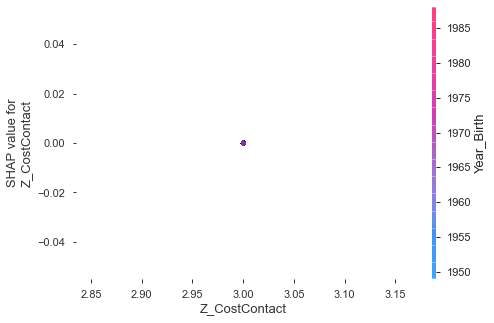

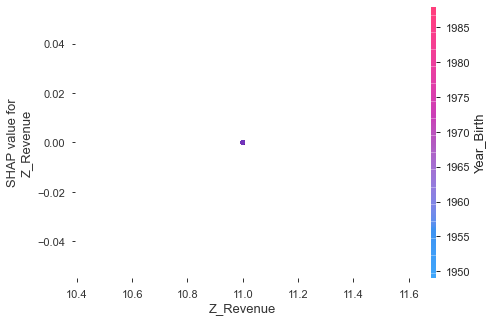

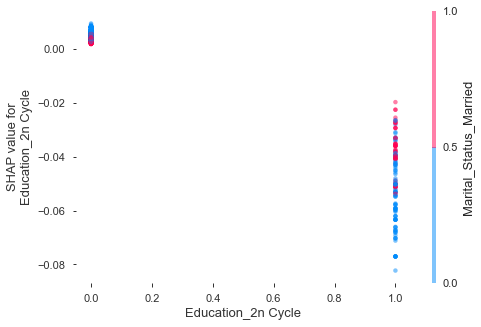

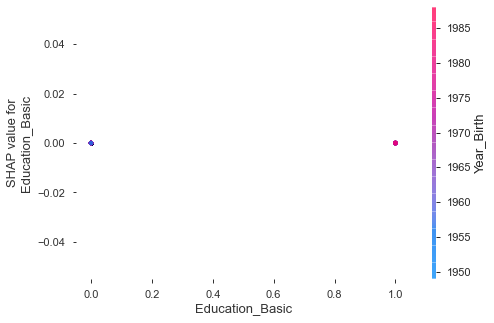

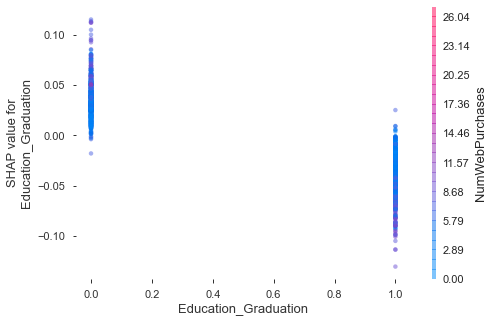

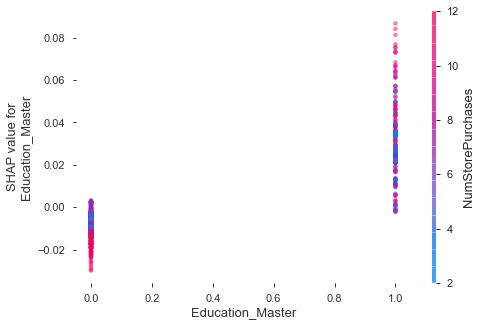

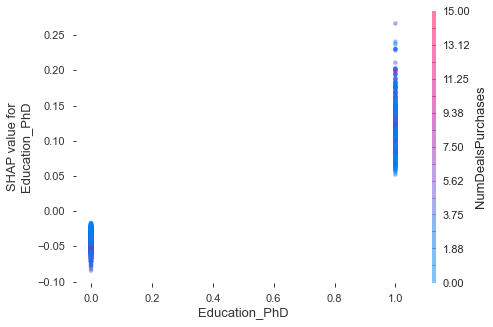

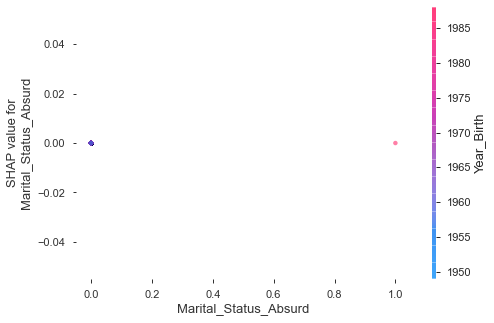

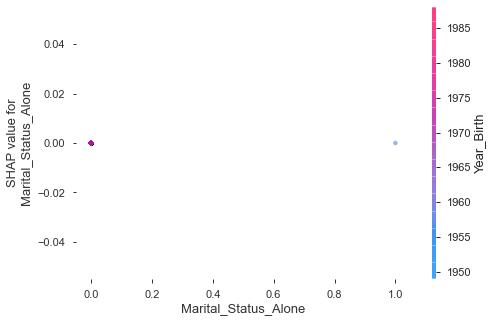

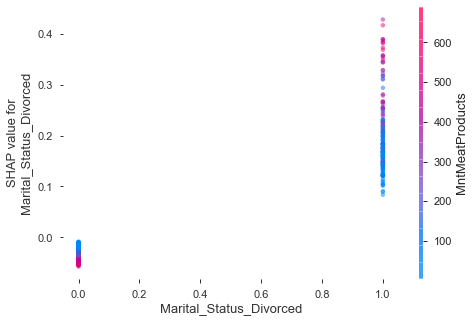

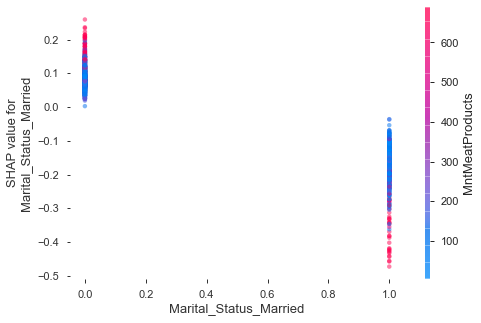

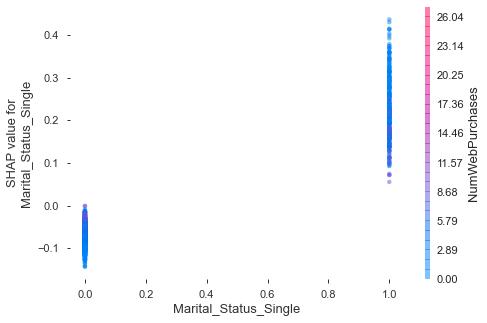

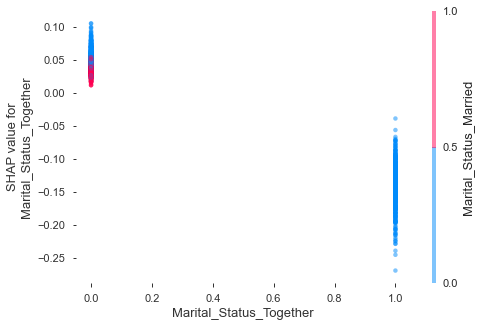

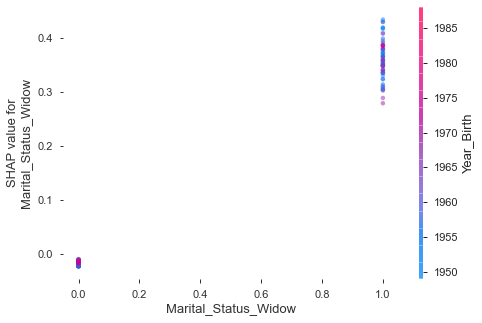

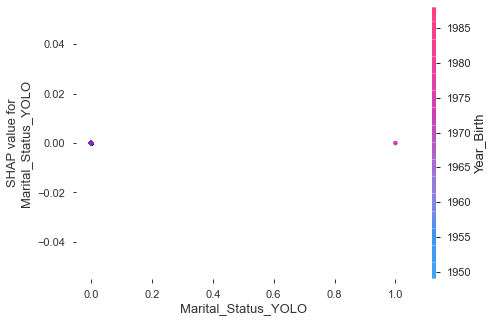

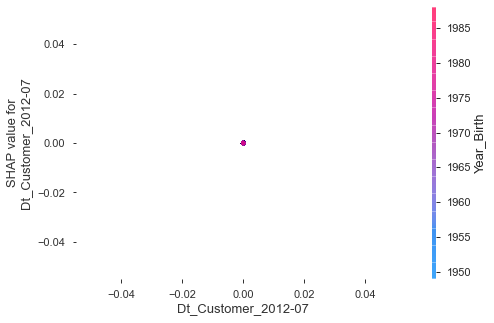

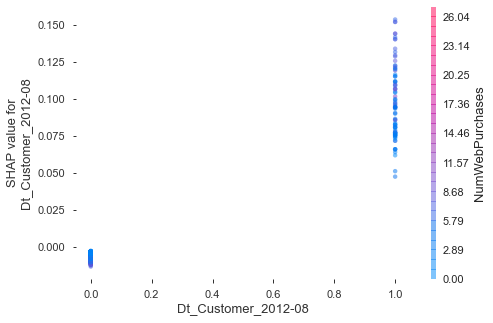

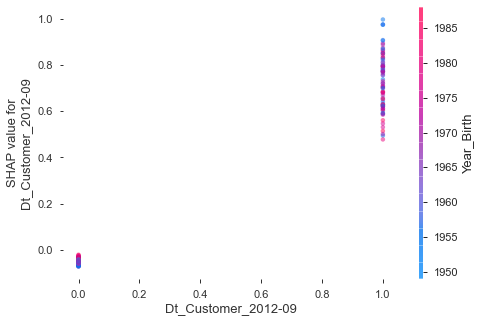

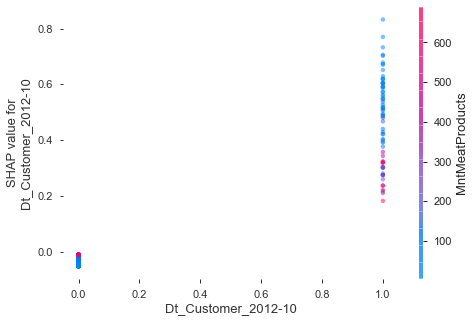

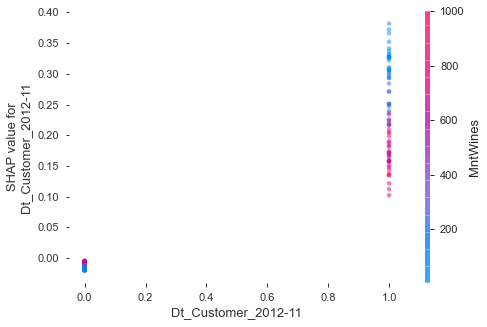

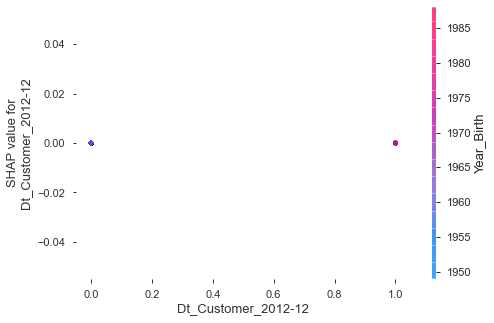

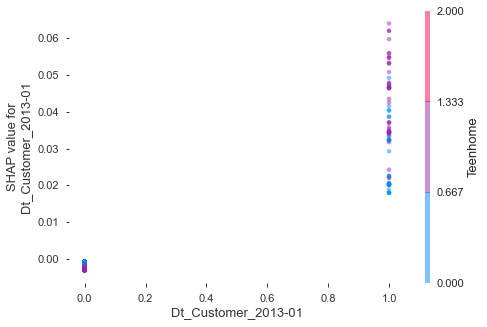

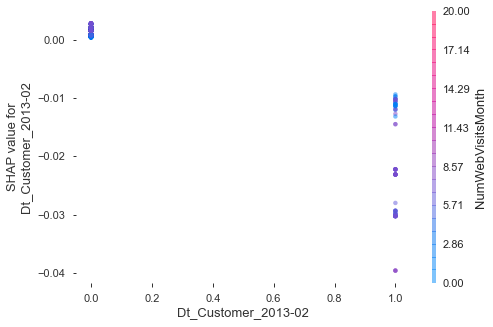

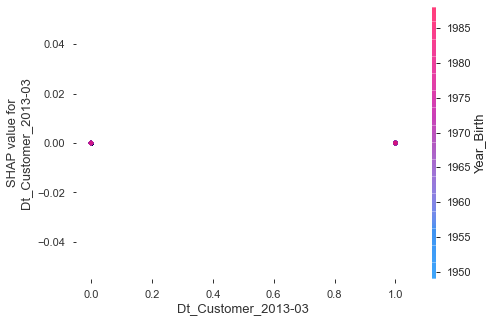

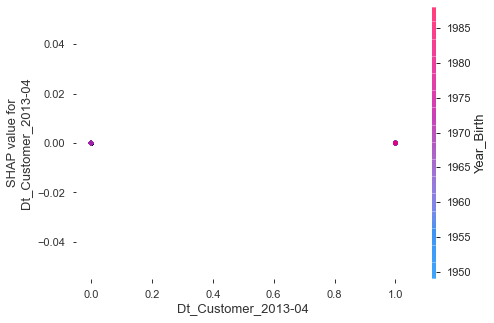

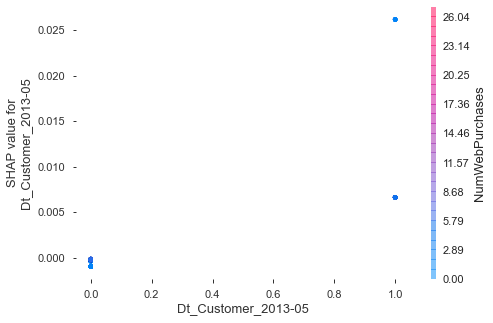

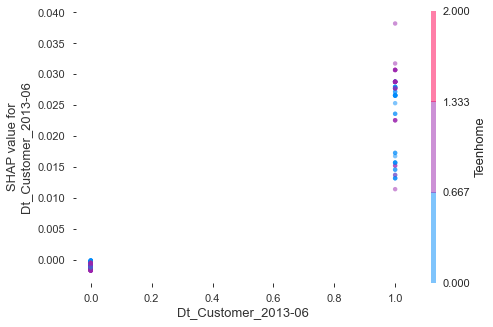

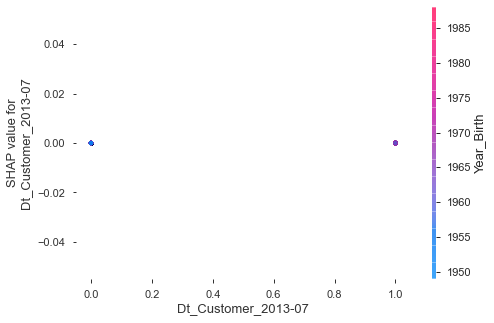

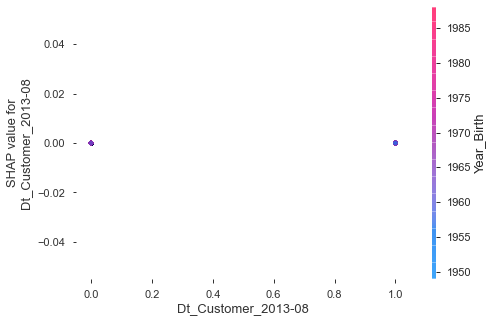

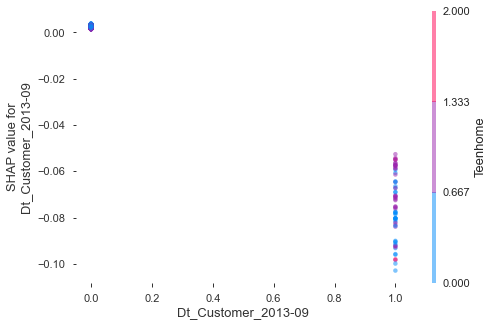

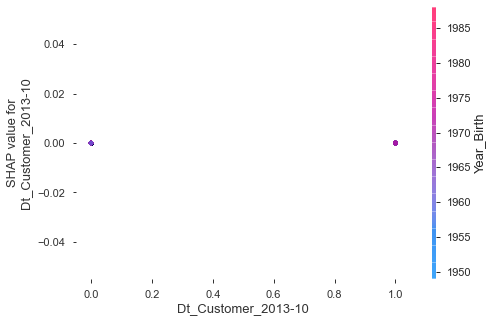

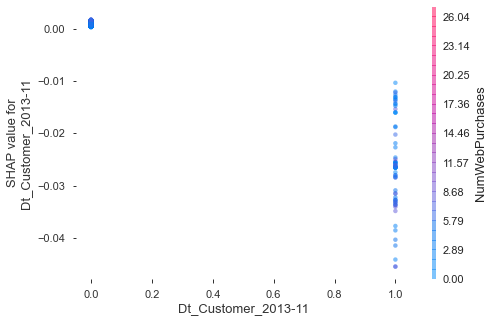

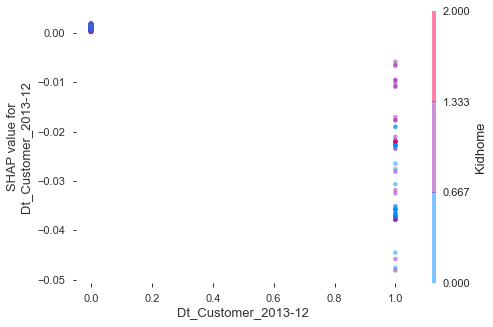

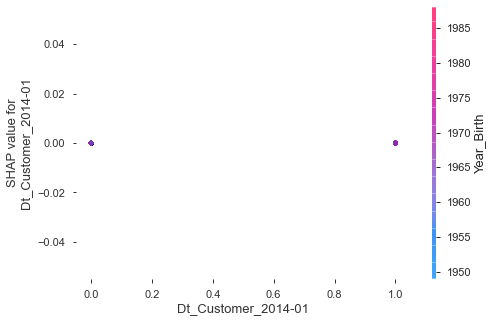

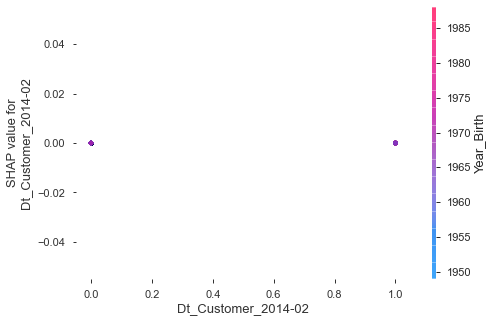

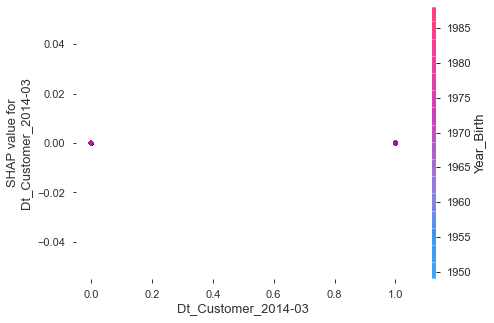

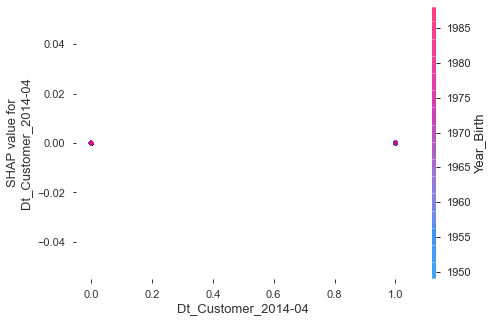

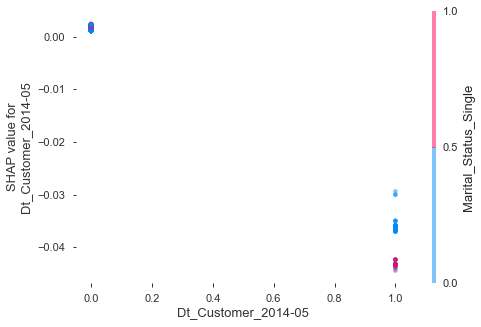

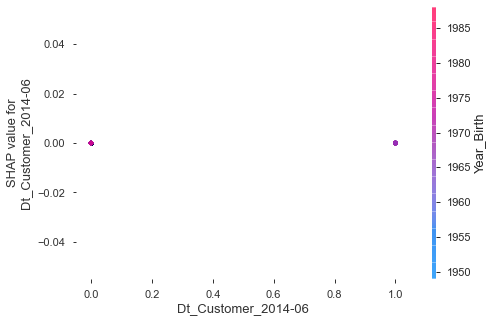

In [20]:
for feature in features:
    shap.dependence_plot(feature, shap_values, X_train, interaction_index='auto',
                             alpha=0.5, dot_size=20, show=False)

## Making sense of the results 

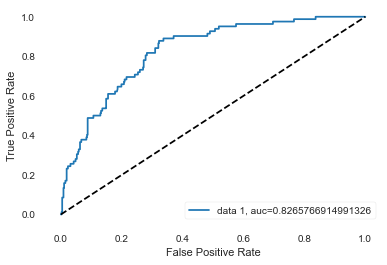

In [21]:
y_pred_proba = my_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [22]:
probs = my_model.predict_proba(X_test)[:,1]

## Precision Recall Curve

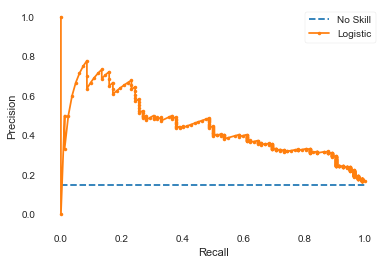

In [23]:
from sklearn.metrics import precision_recall_curve
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Quantile Bar Graph

In [24]:
def get_bins(scores, q=10, adjust_endpoints=False):
    _, bins =  pd.qcut(scores, q=q, retbins=True)
    if adjust_endpoints:
        bins[0] = -0.1
        bins[len(bins)-1] = 1.1
    return bins

In [25]:
#get_bins(scores, y_pred_proba)
bins = get_bins(probs, q=10, adjust_endpoints=True)

In [26]:
def get_quantiles_from_bins(scores, bins, one_high=True):
    quantiles = pd.Series(np.digitize(scores, bins, right=True))
    if one_high:
        q = len(bins)-1
        quantiles = q - quantiles + 1
    return quantiles

In [27]:
get_quantiles_from_bins(scores, bins, one_high=True)

0    1
dtype: int64

In [28]:
def plot_quantiles(target, probs, q=10, figsize=(8,5),
                   title='Quantile Bar Graph'):

    if q==10:
        quant_type = 'Decile'
    elif q==20:
        quant_type = 'Ventile'
    else:
        quant_type = 'Quantile'

    # Get quantiles from probabilities
    bins = get_bins(probs, q=q, adjust_endpoints=True)
    quantiles = get_quantiles_from_bins(probs, bins, one_high=True)

    # Calculate event rate for each quantile
    quantile_labels = sorted(set(quantiles))
    rates = []
    for q in quantile_labels:
        arr = target[quantiles == q]
        pos_vals = arr.sum()
        rate = pos_vals / float(len(arr))
        rates.append(rate)

    # Plot event rate for each quantiles
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(quantile_labels, rates, align='center')
    ax.set_xticks(quantile_labels)
    plt.title(title)
    plt.ylabel('Event Rate')
    plt.xlabel(quant_type)
    plt.close(fig)
    return fig

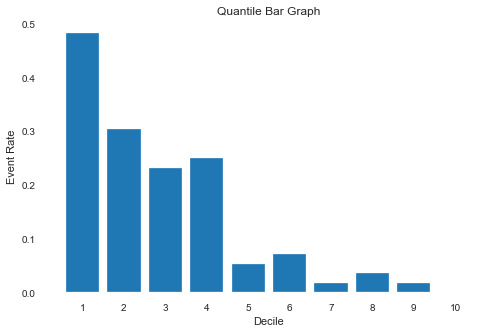

In [29]:
plot_quantiles(y_test, probs)

## Predition Density plot

In [30]:
def plot_prediction_density(target, probs, figsize=(8,5),
                            title='Prediction Density Plot'):

    class_set = sorted(set(target))

    x_grid = np.linspace(0, 1, 1000)

    fig, ax = plt.subplots(figsize=figsize)
    for value in class_set:
        arr = probs[target == value]
        kernel = gaussian_kde(arr, bw_method='scott')
        kde = kernel.evaluate(x_grid)
        ax.plot(x_grid, kde, linewidth=2.5, label='Target = {}'.format(value))
        ax.fill_between(x_grid, kde, alpha=0.6)
    plt.title(title)
    plt.xlabel('Model Score')
    plt.ylabel('Kernel Density')
    plt.legend()
    plt.close(fig)
    return fig



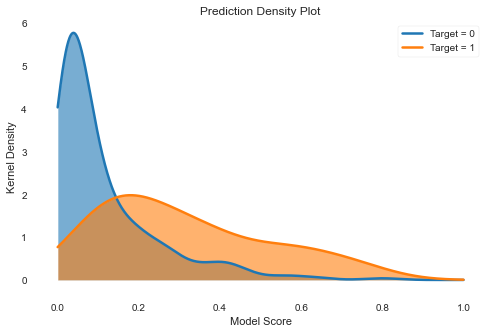

In [31]:
plot_prediction_density(pd.Series(y_test[:,0]), probs)

In [32]:
from sklearn.metrics import confusion_matrix

y_pred = my_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[469,   9],
       [ 63,  19]], dtype=int64)

In [33]:
conf_matrix_neg = conf_matrix[0,1]+conf_matrix[1,0]
conf_matrix_pos = conf_matrix[0,0]+conf_matrix[1,1]
conf_matrix_score = 1 - conf_matrix_neg/conf_matrix_pos
conf_matrix_score

0.8524590163934427

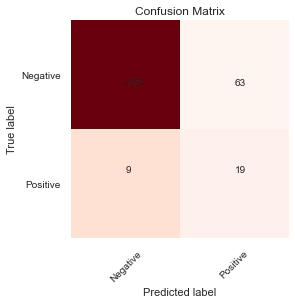

In [34]:
plt.clf()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Reds)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.text(0,0+.1, str(conf_matrix[0][0]))
plt.text(0,1-.1, str(conf_matrix[0][1]))
plt.text(1,0+.1, str(conf_matrix[1][0]))
plt.text(1,1-.1, str(conf_matrix[1][1]))


plt.show()